# Heart failure prediction

Kaggle dataset from: https://www.kaggle.com/fedesoriano/heart-failure-prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier 

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_validate

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm

# Selecting color palette
color_palette = 'rocket'

## Info about the data

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

## Loading the data 

In [2]:
df = pd.read_csv('heart.csv')     # Load the dataset
df.info()                         # Checking the info of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [3]:
df.head(10)

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   
5   39   M           NAP        120          339          0     Normal    170   
6   45   F           ATA        130          237          0     Normal    170   
7   54   M           ATA        110          208          0     Normal    142   
8   37   M           ASY        140          207          0     Normal    130   
9   48   F           ATA        120          284          0     Normal    120   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
5              N      0.0       Up             0  
6              N      0.0       Up             0  
7              N      0.0       Up             0  
8              Y      1.5     Flat             1  
9              N      0.0       Up             0

## Data exploration

### Unique values

In [4]:
# Let's see how many different values we have for each feature
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique values.')

Age: 50 unique values.
Sex: 2 unique values.
ChestPainType: 4 unique values.
RestingBP: 67 unique values.
Cholesterol: 222 unique values.
FastingBS: 2 unique values.
RestingECG: 3 unique values.
MaxHR: 119 unique values.
ExerciseAngina: 2 unique values.
Oldpeak: 53 unique values.
ST_Slope: 3 unique values.
HeartDisease: 2 unique values.


### Duplicated rows

In [5]:
# Check for duplicates
df.duplicated().sum()

0

### Categorical and numerical columns

In [6]:
# Check categorical and numerical columns
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [7]:
# Get two lists with categorical and numerical columns (not counting the binary output)
cat_feats = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
num_feats = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [8]:
# Which are the different categorical values
for col in cat_feats:
    print(f'{col}: {df[col].unique()}')

Sex: ['M' 'F']
ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']
FastingBS: [0 1]
RestingECG: ['Normal' 'ST' 'LVH']
ExerciseAngina: ['N' 'Y']
ST_Slope: ['Up' 'Flat' 'Down']


### Missing values

In [9]:
# Check for missing values on each column
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Correlation between values

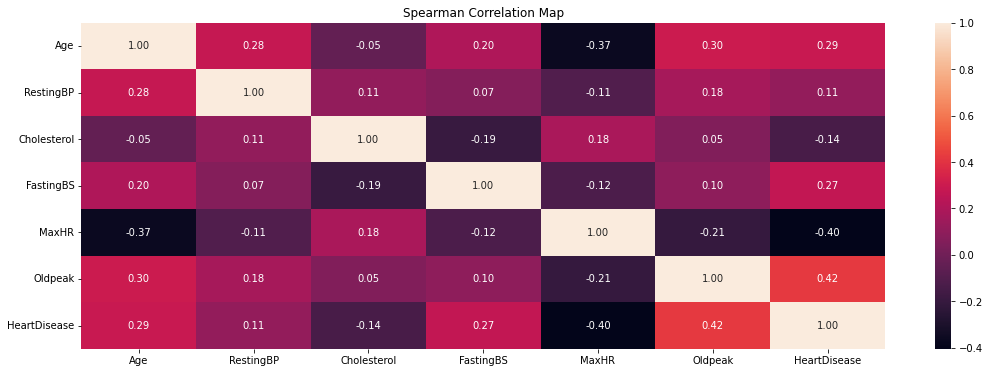

In [10]:
correlation_matrix = df.corr(method = 'spearman')  # get the correlation matrix

# Plot the correlation
plt.figure(figsize = (18, 6))
sns.heatmap(correlation_matrix, annot = True, fmt = '.2f', cmap = color_palette)
plt.title('Spearman Correlation Map')
plt.show()

In [11]:
# Let's get the distribution of the numerical columns w.r.t heart disease
cols_distribution = num_feats
cols_distribution.append('HeartDisease')
cols_distribution

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']

<Figure size 1296x864 with 0 Axes>

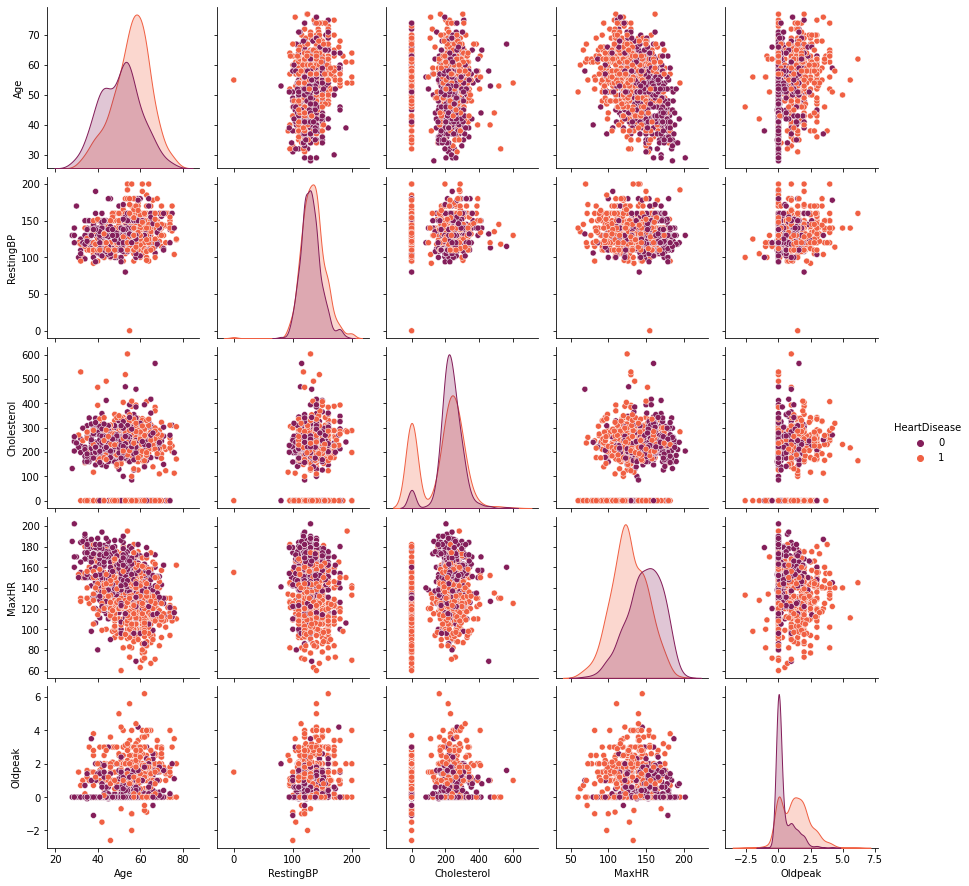

In [12]:
# Plotting
plt.figure(figsize = (18,12))
sns.pairplot(df[cols_distribution], hue = 'HeartDisease', palette = color_palette)
plt.show()

I noticed that for <span style="color:green">'Cholesterol'</span>. and <span style="color:green">'Oldpeak'</span> features, there are quite a few values as 0. 

In [13]:
# Check how many Cholesterol values are equal to 0
count_chol_0 = df.loc[df['Cholesterol'] == 0, 'Cholesterol'].count()
print(f'Cholesterol values == 0: {count_chol_0}')

# Check how many Cholesterol values are equal to 0 and have HeartDisease equal to 1
count_chol_hf_0 = df.loc[(df['Cholesterol'] == 0) & (df['HeartDisease'] == 1), 'Cholesterol'].count()
print(f'Cholesterol values == 0 and HeartDisease == 1: {count_chol_hf_0}')

Cholesterol values == 0: 172
Cholesterol values == 0 and HeartDisease == 1: 152


In [14]:
# Check how many Oldpeak values are equal to 0
count_oldp_0 = df.loc[df['Oldpeak'] == 0, 'Oldpeak'].count()
print(f'Oldpeak values == 0: {count_oldp_0}')

# Check how many Oldpeak values are equal to 0 and have HeartDisease equal to 1
count_oldp_hf_0 = df.loc[(df['Oldpeak'] == 0) & (df['HeartDisease'] == 1), 'Oldpeak'].count()
print(f'Oldpeak values == 0 and HeartDisease == 1: {count_oldp_hf_0}')

Oldpeak values == 0: 368
Oldpeak values == 0 and HeartDisease == 1: 124


Probably, all this 0 values have been created to fill the missing data of the original dataset. 

As we see, for the <span style="color:green">'Cholesterol'</span> features, most of the values equal to 0 have a <span style="color:green">'HeartDisease'</span> value to 1. It does not happend the same on the <span style="color:green">'Oldpeaks'</span>, were this condition is way more balanced. Let's just remove the <span style="color:green">'Cholesterol'</span> column for now.

In [15]:
# Removing the Cholesterol column
df.drop('Cholesterol', axis = 1, inplace = True)
num_feats.remove('Cholesterol')

### Outliers numerical

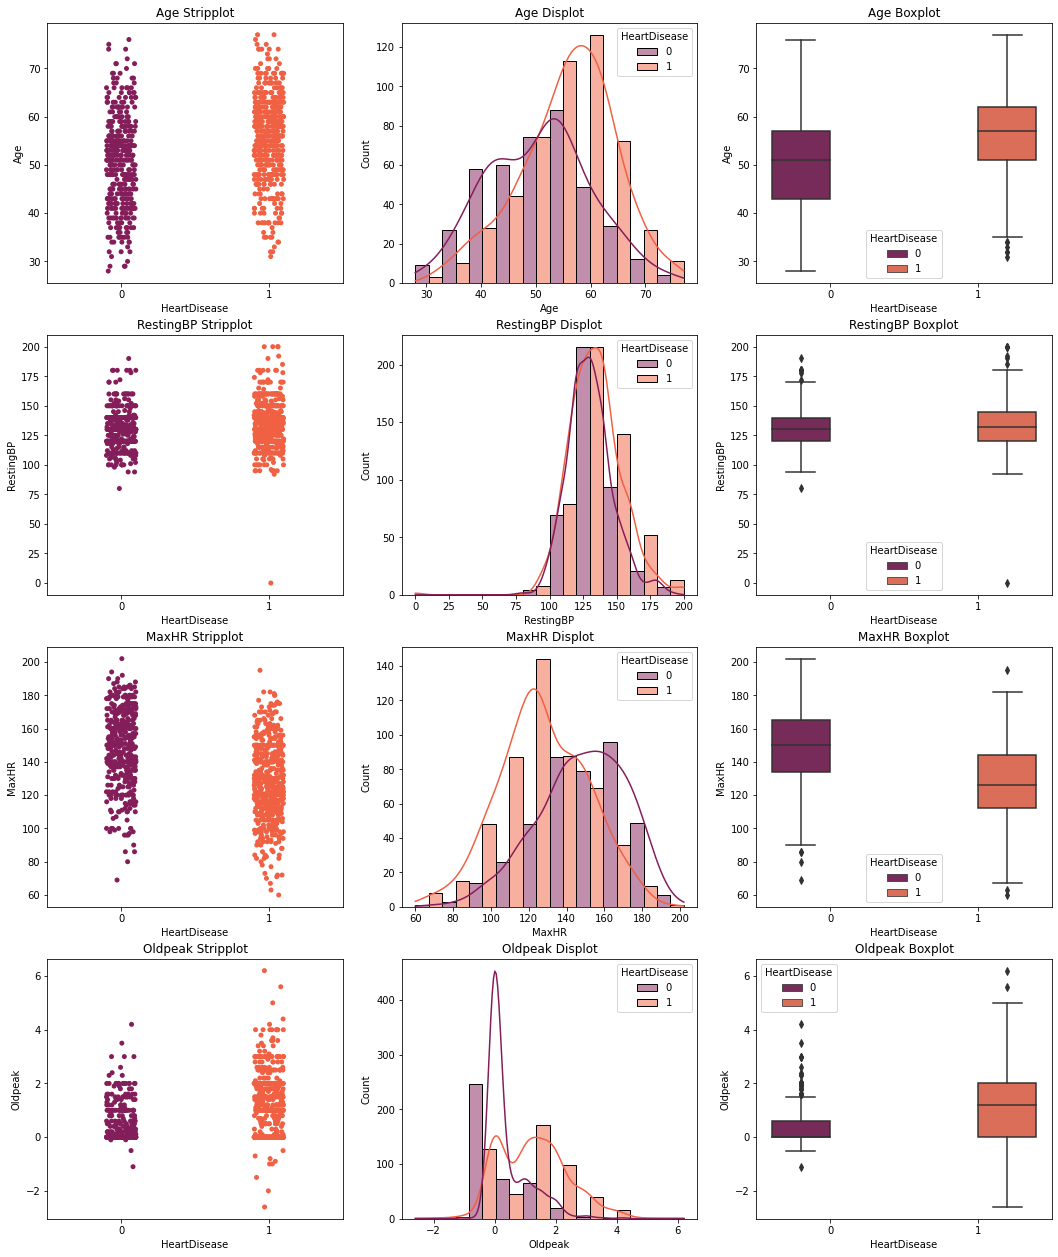

In [16]:
# Plotting numerical values to check if there are outliers
fig, axes = plt.subplots(4, 3, figsize = (18, 22))

for k, col in zip(range(4), num_feats):
    sns.stripplot(ax = axes[k][0], x = 'HeartDisease', y = col, data = df, palette = color_palette, jitter = True)
    axes[k][0].set_title(f'{col} Stripplot')

    sns.histplot(ax = axes[k][1], x = col, data = df, kde = True, bins = 10, palette = color_palette, hue = 'HeartDisease', multiple = 'dodge')
    axes[k][1].set_title(f'{col} Displot')

    sns.boxplot(ax = axes[k][2], x = 'HeartDisease', y = col, data = df, palette = color_palette, hue = 'HeartDisease')
    axes[k][2].set_title(f'{col} Boxplot')

We can see some outliers on the above plot. Let's replace them. For now we will set a threshold with the interquartile range.

In [17]:
# Get the upper and lower limits
def outlier_limits(df, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Replace the values with the limits
def replace_with_limits(df, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_limits(df, variable, q1 = q1, q3 = q3)
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit

In [18]:
# Replace outliers
for variable in num_feats:
    replace_with_limits(df, variable)

Let's see if all the outliers are gone.

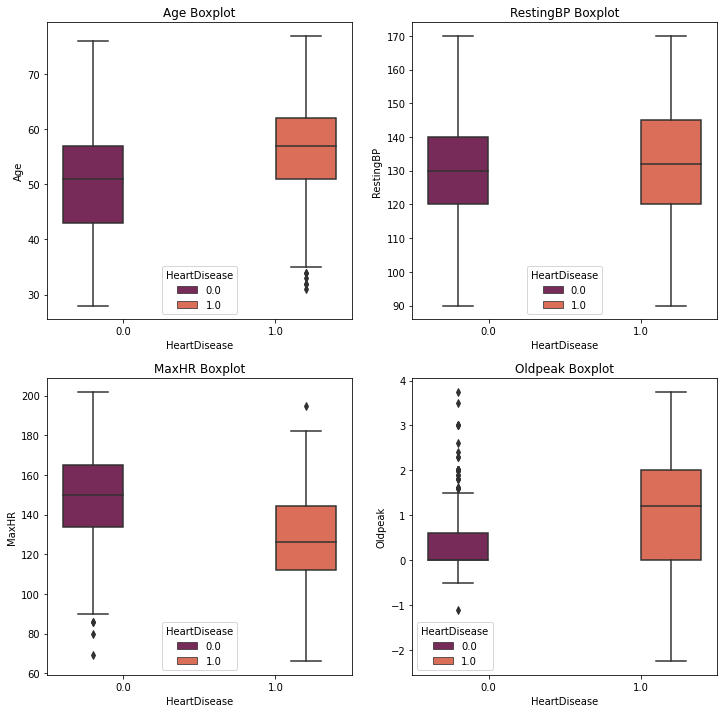

In [19]:
fig, axes = plt.subplots(2, 2, figsize = (12, 12))

for k, col in zip(range(4), num_feats):
    sns.boxplot(ax = axes[k//2][k%2], x = 'HeartDisease', y = col, data = df, palette = color_palette, hue = 'HeartDisease')
    axes[k//2][k%2].set_title(f'{col} Boxplot')

### Categorical Exploration

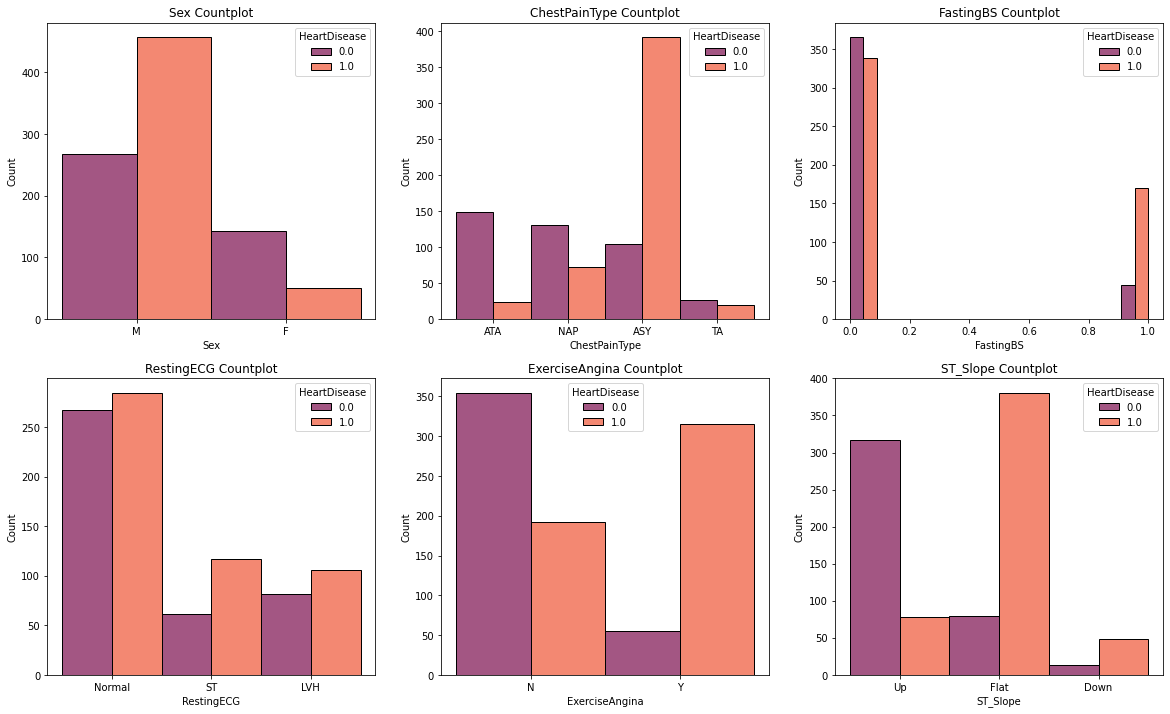

In [20]:
# Let's barplot the counts for each categorical feature
fig, axes = plt.subplots(2, 3, figsize=(20,12))

for i, col in zip(range(6), cat_feats):
    sns.histplot(ax = axes[i//3][i%3], x = col, data = df, palette = color_palette, hue = 'HeartDisease', multiple = 'dodge', bins = 'auto')
    axes[i//3][i%3].set_title(f'{col} Countplot')

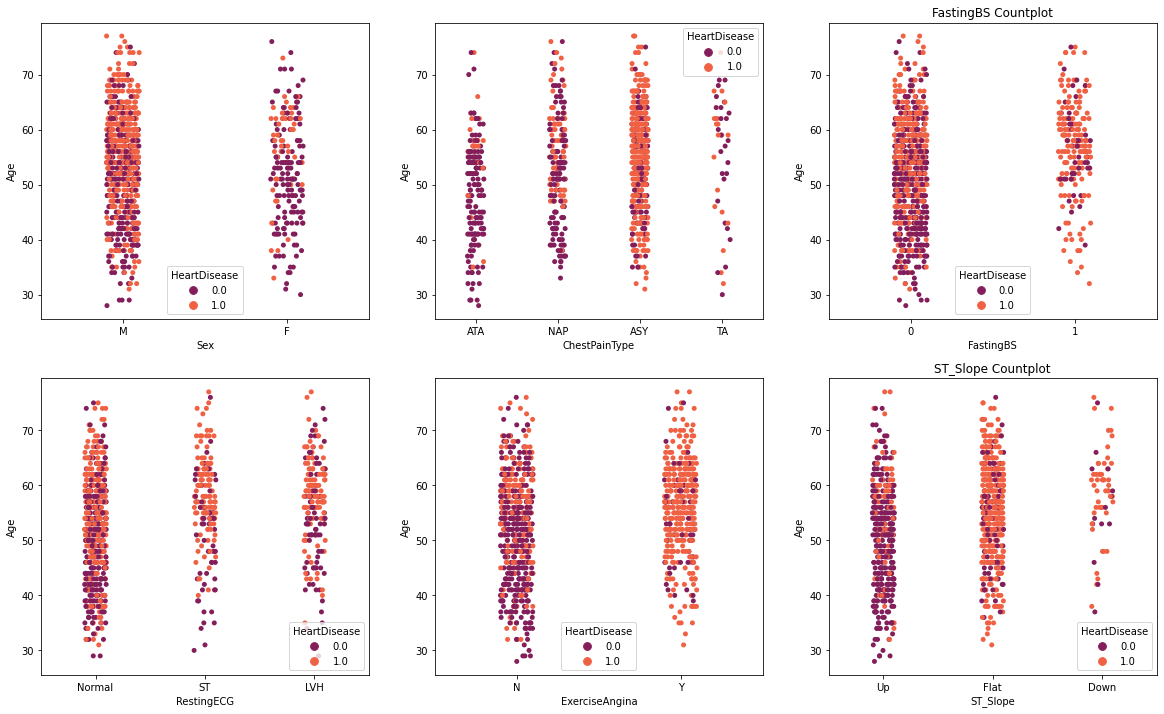

In [21]:
# Let's plot in function of the Age 
fig, axes = plt.subplots(2, 3, figsize=(20,12))

for k, col in zip(range(6), cat_feats):
    sns.stripplot(ax = axes[k//3][k%3], x = col, y = 'Age', data = df, palette = 'rocket', hue = 'HeartDisease', jitter = True)
    axes[k//3][i%3].set_title(f'{col} Countplot')

## Encoding and Dimensionality Reduction

In [22]:
num_feats.remove('HeartDisease')
num_feats, cat_feats

(['Age', 'RestingBP', 'MaxHR', 'Oldpeak'],
 ['Sex',
  'ChestPainType',
  'FastingBS',
  'RestingECG',
  'ExerciseAngina',
  'ST_Slope'])

### Transformers

In [23]:
# We are going to use column transformers to encode certain variables

pca = PCA(n_components = 2)

col_transformer_1 = ColumnTransformer(
    transformers = [
        ('onehotcat', OneHotEncoder(), ['ChestPainType', 'ST_Slope', 'RestingECG', 'Sex', 'ExerciseAngina']),
        ('num', MinMaxScaler(), num_feats)
    ],
    remainder = 'passthrough'
)

col_transformer_2 = ColumnTransformer(
    transformers = [
        ('pca', pca, num_feats)
    ],
    remainder = 'passthrough'
)

col_transformer_1_feats = ['x0_ASY', 'x0_ATA', 'x0_NAP', 'x0_TA', 'x1_Down', 'x1_Flat', 'x1_Up', 
'x2_LVH', 'x2_Normal', 'x2_ST', 'x3_F', 'x3_M', 'x4_N', 'x4_Y', 'Age', 'RestingBP', 'MaxHR', 
'Oldpeak', 'FastingBS']

final_feats = ['PC-1', 'PC-2', 'x0_ATA', 'x0_NAP', 'x0_TA', 'x1_Flat', 'x1_Up', 'x2_Normal', 
'x2_ST', 'x3_M', 'x4_Y', 'FastingBS']

In [24]:
# Get X and y dataframes
X = df.iloc[:,:10]
y = df.iloc[:,10]

X.head(5)

Age Sex ChestPainType  RestingBP  FastingBS RestingECG  MaxHR  \
0  40.0   M           ATA        140          0     Normal    172   
1  49.0   F           NAP        160          0     Normal    156   
2  37.0   M           ATA        130          0         ST     98   
3  48.0   F           ASY        138          0     Normal    108   
4  54.0   M           NAP        150          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  
0              N      0.0       Up  
1              N      1.0     Flat  
2              N      0.0       Up  
3              Y      1.5     Flat  
4              N      0.0       Up

In [25]:
# Apply the first transformation
X = pd.DataFrame(col_transformer_1.fit_transform(X), columns = col_transformer_1_feats)

# we drop 1 feature from each feature that was one hot encoded to avoid multicolinearity
X = X.drop(['x0_ASY', 'x1_Down', 'x2_LVH', 'x3_F', 'x4_N'], axis = 1) 

# Apply the second transformation (pca)
X = pd.DataFrame(col_transformer_2.fit_transform(X), columns = final_feats)
X.head()


PC-1      PC-2  x0_ATA  x0_NAP  x0_TA  x1_Flat  x1_Up  x2_Normal  \
0  0.268472  0.314646     1.0     0.0    0.0      0.0    1.0        1.0   
1 -0.094260  0.372504     0.0     1.0    0.0      1.0    0.0        1.0   
2  0.136854 -0.067667     1.0     0.0    0.0      0.0    1.0        0.0   
3 -0.105074 -0.037640     0.0     0.0    0.0      1.0    0.0        1.0   
4 -0.136472  0.120718     0.0     1.0    0.0      0.0    1.0        1.0   

   x2_ST  x3_M  x4_Y  FastingBS  
0    0.0   1.0   0.0        0.0  
1    0.0   0.0   0.0        0.0  
2    1.0   1.0   0.0        0.0  
3    0.0   0.0   1.0        0.0  
4    0.0   1.0   0.0        0.0

### Check for multillinearity 

We are going to use the Variable Inflation Factors (VIF) method. If VIF > 5, it means that the features shows multicollinearity.

In [26]:
# Function to compute the VIF 
def compute_vif(data):

    vif_df = pd.DataFrame(columns = ['Feature', 'VIF'])             # create the dataframe
    x_var_names = data.columns     

    for k in range(0, x_var_names.shape[0]):
        y = data[x_var_names[k]]
        x = data[x_var_names.drop([x_var_names[k]])]

        r_squared = sm.OLS(y,x).fit().rsquared                      # compute VIF
        vif = round(1/(1-r_squared),2)
        
        vif_df.loc[k] = [x_var_names[k], vif]

    return vif_df.sort_values(by = 'VIF', axis = 0, ascending=False, inplace=False)

compute_vif(X)

Feature   VIF
9        x3_M  4.38
5     x1_Flat  4.10
6       x1_Up  4.06
7   x2_Normal  3.67
10       x4_Y  2.35
8       x2_ST  1.90
2      x0_ATA  1.75
3      x0_NAP  1.51
0        PC-1  1.38
11  FastingBS  1.37
1        PC-2  1.13
4       x0_TA  1.13

We can see how, having applied PCA, we dont have any features that present multicollinearity.

## Machine Learning algorithms

### Split into train and test

In [27]:
# Let's split tha data into train and test datasets
# For now, we will use 80% of the data for training and 20% for test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

In [28]:
# Initialise pandas dataframe for results
df_results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Recall', 'Precision', 'F1-score', 'ROC-AUC'])
df_results.head()

Empty DataFrame
Columns: [Model, Accuracy, Recall, Precision, F1-score, ROC-AUC]
Index: []

### Useful functions

In [29]:
# Fitting function usgin GridSearchCV
def fit(classifier, params, X, y, k_fold_splits = 10):

    # initialise the GridSearchCV
    grid = GridSearchCV(                             
        classifier, 
        params,
        cv = KFold(n_splits = k_fold_splits),
        n_jobs = 1,
        verbose = 1,
        return_train_score = True,
        scoring = 'accuracy',
        refit = True
        )

    # Fit the model
    grid.fit(X, y)                                   
    
    return grid

# Predictions function
def predict(model, X):
    # Make predictions with the model
    predictions = model.predict(X)
    return predictions

# Plot confusion matrix
def plot_confussion_matrix(y):

    conf_matrix = confusion_matrix(y_true = y_test, y_pred = y)

    fig, ax = plt.subplots(figsize = (6, 6))
    ax.matshow(conf_matrix, cmap = color_palette, alpha = 0.75)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'large') 
    plt.xlabel('Predictions', fontsize = 14)
    plt.ylabel('Actuals', fontsize = 14)
    plt.title('Confusion Matrix', fontsize = 14)
    plt.show()    

# Print the best parameters and best score
def print_bests(model):
    print(f'The best parameters are: {model.best_params_}')          # best parameters
    print(f'The best score that we got is: {model.best_score_}')     # best score

# Print the scores obtained
def get_scores(model, y_test, y_pred, df_results):

    # Get scores
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    rocauc = roc_auc_score(y_test, y_pred)

    # Print score
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('Accuracy: %.3f' % accuracy)
    print('F1 Score: %.3f' % f1score)
    print('ROC-AUC Score: %.3f' % rocauc)

    # Create results dictionnary
    dict_results = {                
        'Model': model,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1-score': f1score,
        'ROC-AUC': rocauc
    }

    # Add results to the results dataframe
    df_results = df_results.append(dict_results, ignore_index = True)

    return df_results


### Logistic Regression

In [30]:
# Dictionnary with the parameters
logistic_regression_parameters = {
    'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
    'penalty': ['l1', 'l2']
}

# Initialise the classifier
logistic_regression_clf = LogisticRegression(
    solver = 'saga', 
    max_iter = 6000
    )

# Fit the model
logistic_regression_model = fit(
    logistic_regression_clf,
    logistic_regression_parameters,
    X_train,
    y_train
)

print_bests(logistic_regression_model)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
The best parameters are: {'C': 0.09, 'penalty': 'l2'}
The best score that we got is: 0.8554609403924471


In [31]:
# Make the predictions on the test
logistic_regression_predictions = predict(
    logistic_regression_model,
    X_test
    )

# Print the scores
df_results = get_scores('Logistic Regression', y_test, logistic_regression_predictions, df_results)
df_results.head()

Precision: 0.873
Recall: 0.873
Accuracy: 0.859
F1 Score: 0.873
ROC-AUC Score: 0.857


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0  Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006

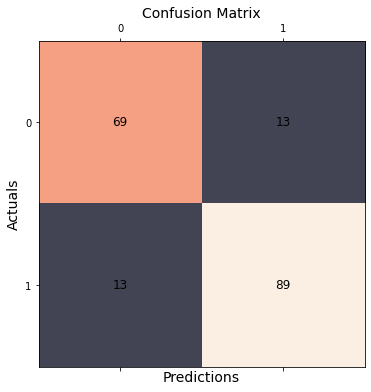

In [32]:
# Get the confussion matrix
plot_confussion_matrix(logistic_regression_predictions)

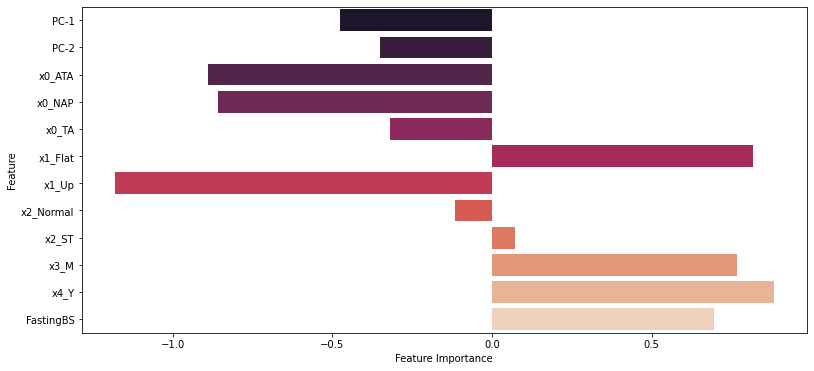

In [33]:
# Get the features importances
logistic_regression_feature_scores = logistic_regression_model.best_estimator_.coef_[0].tolist()

# Create the dataframe
logistic_regression_feature_importance = pd.DataFrame({
    'Feature': final_feats, 
    'Feature Importance': logistic_regression_feature_scores
    })

# PLot the feature importances
plt.figure(figsize = (13, 6))
sns.barplot(
    x = 'Feature Importance', 
    y = 'Feature', 
    data = logistic_regression_feature_importance, 
    palette = color_palette
    )
plt.show()

### Gaussian Naive Bayes

In [34]:
# Dictionnary with the parameters
gnb_parameters = {
    'priors': [None],
    'var_smoothing': np.logspace(0, -9, num = 100)
}

# Initialise the model
gnb_clf = GaussianNB()

# Fit the model
gnb_model = fit(
    gnb_clf,
    gnb_parameters, 
    X_train, 
    y_train
)

print_bests(gnb_model)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
The best parameters are: {'priors': None, 'var_smoothing': 0.08111308307896872}
The best score that we got is: 0.8554794520547946


In [35]:
# Make the predictions on the test
gnb_predictions = predict(
    gnb_model,
    X_test
    )

# Print the scores
df_results = get_scores('Gaussin Naive Bayes', y_test, gnb_predictions, df_results)
df_results.head()

Precision: 0.898
Recall: 0.863
Accuracy: 0.870
F1 Score: 0.880
ROC-AUC Score: 0.870


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0  Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1  Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397

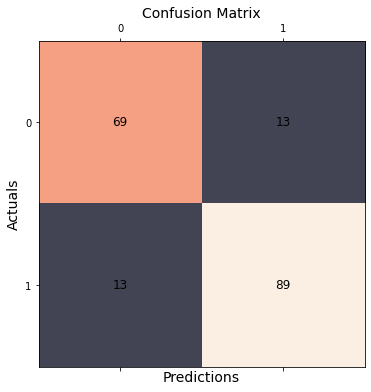

In [36]:
# Get the confussion matrix
plot_confussion_matrix(logistic_regression_predictions)

### K-Nearest Neighbors

In [37]:
# Dictionnary with the parameters
knn_parameters = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan']
}

# Initialise the model
knn_clf = KNeighborsClassifier()

# Fit the model
knn_model = fit(
    knn_clf, 
    knn_parameters,
    X_train, 
    y_train
    )

print_bests(knn_model)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
The best parameters are: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
The best score that we got is: 0.8541651240281377


In [38]:
# Make the predictions on the test
knn_predictions = predict(
    knn_model,
    X_test
    )

# Print the scores
df_results = get_scores('KNN', y_test, knn_predictions, df_results)
df_results.head()

Precision: 0.877
Recall: 0.912
Accuracy: 0.880
F1 Score: 0.894
ROC-AUC Score: 0.877


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0  Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1  Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397
2                  KNN  0.880435  0.911765   0.877358  0.894231  0.876614

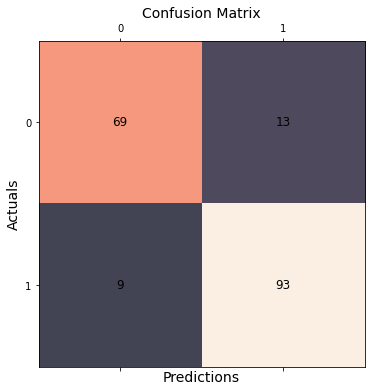

In [39]:
# Get the confussion matrix
plot_confussion_matrix(knn_predictions)

### Support Vector Machine

In [40]:
# Dictionnary with the parameters
svm_parameters = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 
    'kernel': ['linear', 'rbf']
}

# Initialise the model
svm_clf = SVC()

# Fit the model
svm_model = fit(
    svm_clf, 
    svm_parameters,
    X_train, 
    y_train
    )

print_bests(svm_model)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
The best parameters are: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
The best score that we got is: 0.8567937800814512


In [41]:
# Make the predictions on the test
svm_predictions = predict(
    svm_model,
    X_test
    )

# Print the scores
df_results = get_scores('SVM', y_test, svm_predictions, df_results)
df_results.head()

Precision: 0.847
Recall: 0.922
Accuracy: 0.864
F1 Score: 0.883
ROC-AUC Score: 0.857


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0  Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1  Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397
2                  KNN  0.880435  0.911765   0.877358  0.894231  0.876614
3                  SVM  0.864130  0.921569   0.846847  0.882629  0.857126

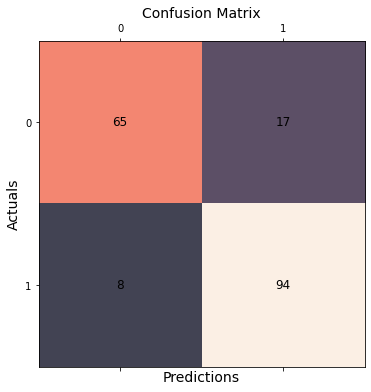

In [42]:
# Get the confussion matrix
plot_confussion_matrix(svm_predictions)

### Decisison Tree

In [43]:
# Dictionnary with the parameters
dt_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10), 
    'min_samples_leaf': range(1, 5)
}

# Initialise the model
dt_clf = DecisionTreeClassifier()

# Fit the model
dt_model = fit(
    dt_clf, 
    dt_parameters,
    X_train, 
    y_train
    )

print_bests(dt_model)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
The best parameters are: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3}
The best score that we got is: 0.8363569048500554


In [44]:
# Make the predictions on the test
dt_predictions = predict(
    dt_model,
    X_test
    )

# Print the scores
df_results = get_scores('Decision Tree', y_test, dt_predictions, df_results)
df_results.head()

Precision: 0.850
Recall: 0.833
Accuracy: 0.826
F1 Score: 0.842
ROC-AUC Score: 0.825


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0  Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1  Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397
2                  KNN  0.880435  0.911765   0.877358  0.894231  0.876614
3                  SVM  0.864130  0.921569   0.846847  0.882629  0.857126
4        Decision Tree  0.826087  0.833333   0.850000  0.841584  0.825203

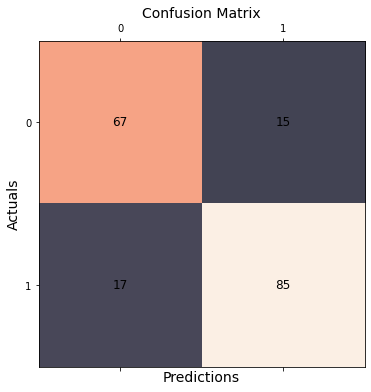

In [45]:
# Get the confussion matrix
plot_confussion_matrix(dt_predictions)

### Random Forest

In [46]:
# Dictionnary with the parameters
rf_parameters = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [8, 10, 12], 
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [100, 250, 500, 600, 700, 800, 900, 1000]
}

# Initialise the model
rf_clf = RandomForestClassifier()

# Fit the model
rf_model = fit(
    rf_clf, 
    rf_parameters,
    X_train, 
    y_train
    )

print_bests(rf_model)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
The best parameters are: {'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
The best score that we got is: 0.8581266197704555


In [47]:
# Make the predictions on the test
rf_predictions = predict(
    rf_model,
    X_test
    )

# Print the scores
df_results = get_scores('Random Forest', y_test, rf_predictions, df_results)
df_results

Precision: 0.848
Recall: 0.873
Accuracy: 0.842
F1 Score: 0.860
ROC-AUC Score: 0.839


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0  Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1  Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397
2                  KNN  0.880435  0.911765   0.877358  0.894231  0.876614
3                  SVM  0.864130  0.921569   0.846847  0.882629  0.857126
4        Decision Tree  0.826087  0.833333   0.850000  0.841584  0.825203
5        Random Forest  0.842391  0.872549   0.847619  0.859903  0.838714

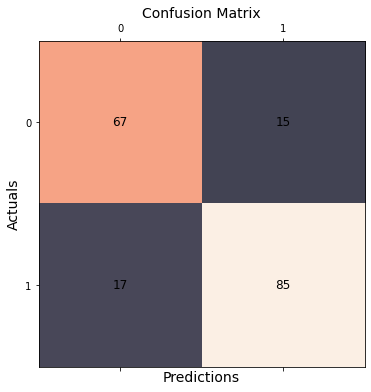

In [48]:
# Get the confussion matrix
plot_confussion_matrix(dt_predictions)

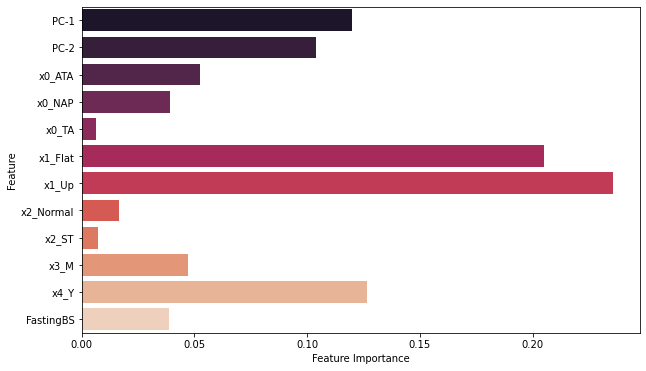

In [49]:
# Get the feature importance
rf_feature_scores = rf_model.best_estimator_.feature_importances_.tolist()

rf_feats = pd.DataFrame({
    'Feature': final_feats, 
    'Feature Importance': rf_feature_scores
    })

plt.figure(figsize=(10,6))
sns.barplot(x = 'Feature Importance', y = 'Feature', data = rf_feats, palette = color_palette)
plt.show()

### Adaboost

In [50]:
# Dictionnary with the parameters
ada_parameters = {
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
    'n_estimators': [100, 200, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]
}

# Initialise the model
ada_clf = AdaBoostClassifier()

# Fit the model
ada_model = fit(
    ada_clf, 
    ada_parameters,
    X_train, 
    y_train
    )

print_bests(ada_model)

Fitting 10 folds for each of 55 candidates, totalling 550 fits
The best parameters are: {'learning_rate': 0.01, 'n_estimators': 400}
The best score that we got is: 0.843169196593854


In [51]:
# Make the predictions on the test
ada_predictions = predict(
    ada_model,
    X_test
    )

# Print the scores
df_results = get_scores('AdaBoost', y_test, ada_predictions, df_results)
df_results

Precision: 0.842
Recall: 0.833
Accuracy: 0.821
F1 Score: 0.837
ROC-AUC Score: 0.819


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0  Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1  Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397
2                  KNN  0.880435  0.911765   0.877358  0.894231  0.876614
3                  SVM  0.864130  0.921569   0.846847  0.882629  0.857126
4        Decision Tree  0.826087  0.833333   0.850000  0.841584  0.825203
5        Random Forest  0.842391  0.872549   0.847619  0.859903  0.838714
6             AdaBoost  0.820652  0.833333   0.841584  0.837438  0.819106

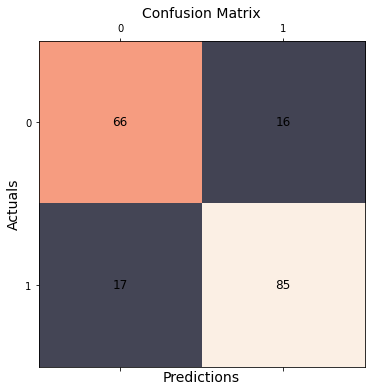

In [52]:
# Get the confussion matrix
plot_confussion_matrix(ada_predictions)

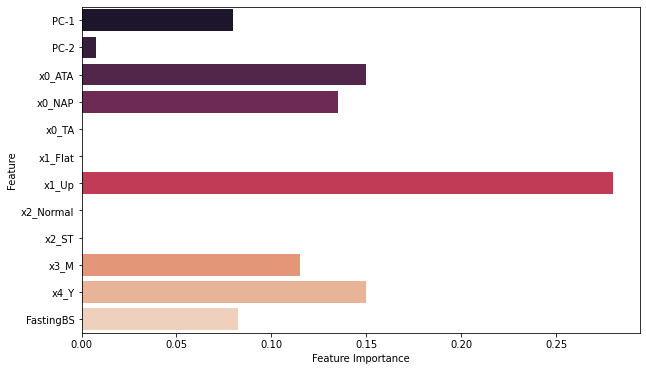

In [53]:
# Get the feature importance
ada_feature_scores = ada_model.best_estimator_.feature_importances_.tolist()

ada_feats = pd.DataFrame({
    'Feature': final_feats, 
    'Feature Importance': ada_feature_scores
    })

plt.figure(figsize=(10,6))

sns.barplot(x = 'Feature Importance', y = 'Feature', data = ada_feats, palette = color_palette)
plt.show()

### Gradient Boosting

In [54]:
# Dictionnary with the parameters
gb_parameters = {
    'loss': ['exponential'],
    'learning_rate': [0.001, 0.0025, 0.005, 0.0075, 0.01],
    'max_depth': [4, 6, 8, 10],
    'max_features': ['log2', 'sqrt'],
    'n_estimators': [100, 250, 400, 500, 600, 750, 1000]
}

# Initialise the model
gb_clf = GradientBoostingClassifier()

# Fit the model
gb_model = fit(
    gb_clf, 
    gb_parameters,
    X_train, 
    y_train
    )

print_bests(gb_model)

Fitting 10 folds for each of 280 candidates, totalling 2800 fits
The best parameters are: {'learning_rate': 0.005, 'loss': 'exponential', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}
The best score that we got is: 0.8567937800814512


In [55]:
# Make the predictions on the test
gb_predictions = predict(
    gb_model,
    X_test
    )

# Print the scores
df_results = get_scores('Gradient Boosting', y_test, gb_predictions, df_results)
df_results

Precision: 0.845
Recall: 0.853
Accuracy: 0.832
F1 Score: 0.849
ROC-AUC Score: 0.829


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0  Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1  Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397
2                  KNN  0.880435  0.911765   0.877358  0.894231  0.876614
3                  SVM  0.864130  0.921569   0.846847  0.882629  0.857126
4        Decision Tree  0.826087  0.833333   0.850000  0.841584  0.825203
5        Random Forest  0.842391  0.872549   0.847619  0.859903  0.838714
6             AdaBoost  0.820652  0.833333   0.841584  0.837438  0.819106
7    Gradient Boosting  0.831522  0.852941   0.844660  0.848780  0.828910

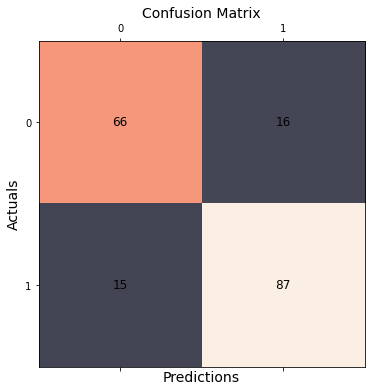

In [56]:
# Get the confussion matrix
plot_confussion_matrix(gb_predictions)

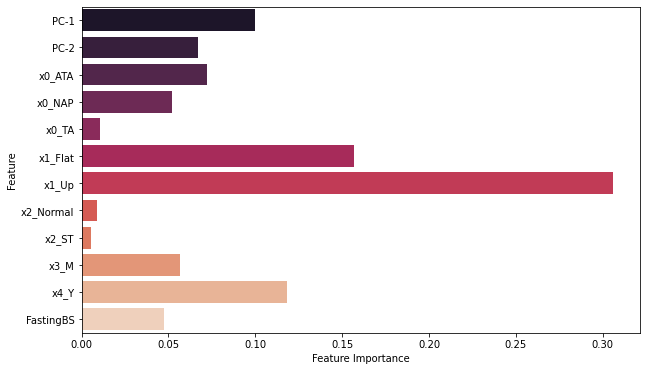

In [57]:
# Get the feature importance
gb_feature_scores = gb_model.best_estimator_.feature_importances_.tolist()

gb_fi = pd.DataFrame({
    'Feature': final_feats, 
    'Feature Importance': gb_feature_scores
    })

plt.figure(figsize = (10,6))
sns.barplot(x = 'Feature Importance', y = 'Feature', data = gb_fi, palette = color_palette)
plt.show()

### Light GBM

In [58]:
# Dictionnary with the parameters
lgbm_parameters = {
    'num_leaves': [5, 10, 15, 20, 25],
    'min_child_samples': [5, 10, 15], 
    'learning_rate': [0.001, 0.0025, 0.005, 0.0075, 0.01], 
    'objective': ['binary']
}

# Initialise the model
lgbm_clf = LGBMClassifier()

# Fit the model
lgbm_model = fit(
    lgbm_clf, 
    lgbm_parameters,
    X_train, 
    y_train
    )

print_bests(lgbm_model)

Fitting 10 folds for each of 75 candidates, totalling 750 fits
The best parameters are: {'learning_rate': 0.01, 'min_child_samples': 5, 'num_leaves': 10, 'objective': 'binary'}
The best score that we got is: 0.8526656793780083


In [59]:
# Make the predictions on the test
lgbm_predictions = predict(
    ada_model,
    X_test
    )

# Print the scores
df_results = get_scores('Light GBM', y_test, lgbm_predictions, df_results)
df_results

Precision: 0.842
Recall: 0.833
Accuracy: 0.821
F1 Score: 0.837
ROC-AUC Score: 0.819


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0  Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1  Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397
2                  KNN  0.880435  0.911765   0.877358  0.894231  0.876614
3                  SVM  0.864130  0.921569   0.846847  0.882629  0.857126
4        Decision Tree  0.826087  0.833333   0.850000  0.841584  0.825203
5        Random Forest  0.842391  0.872549   0.847619  0.859903  0.838714
6             AdaBoost  0.820652  0.833333   0.841584  0.837438  0.819106
7    Gradient Boosting  0.831522  0.852941   0.844660  0.848780  0.828910
8            Light GBM  0.820652  0.833333   0.841584  0.837438  0.819106

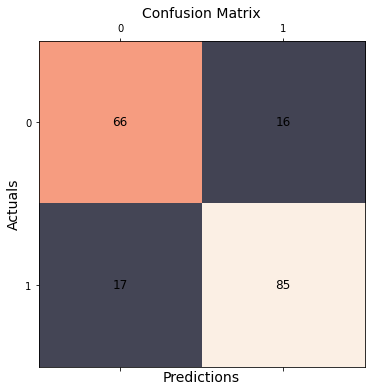

In [60]:
# Get the confussion matrix
plot_confussion_matrix(lgbm_predictions)

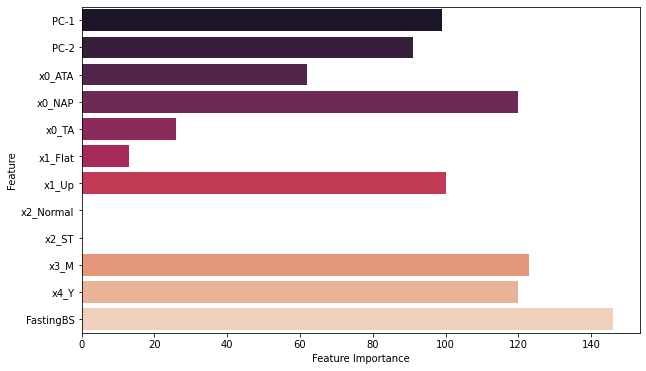

In [61]:
# Get the feature importance
lgbm_feature_scores = lgbm_model.best_estimator_.feature_importances_.tolist()

lgbm_fi = pd.DataFrame({
    'Feature': final_feats, 
    'Feature Importance': lgbm_feature_scores
    })

plt.figure(figsize = (10,6))
sns.barplot(x = 'Feature Importance', y = 'Feature', data = lgbm_fi, palette = color_palette)
plt.show()

### XGBoost

In [64]:
# Dictionnary with the parameters
xgb_parameters = {
    'max_depth': range(2, 10, 1),
    'n_estimators': [50, 100, 250, 400, 550, 750, 1000], 
    'learning_rate': [0.001, 0.0025, 0.005, 0.0075, 0.01], 
    'objective': ['binary:hinge', 'binary:logistic', 'binary:logitraw']
}

# Initialise the model
xgb_clf = XGBClassifier()

# Fit the model
xgb_model = fit(
    xgb_clf, 
    xgb_parameters,
    X_train, 
    y_train
    )

print_bests(xgb_model)

Fitting 10 folds for each of 840 candidates, totalling 8400 fits
[13:42:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:42:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:42:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:4

In [65]:
# Make the predictions on the test
xgb_predictions = predict(
    xgb_model,
    X_test
    )

# Print the scores
df_results = get_scores('XGBoost', y_test, xgb_predictions, df_results)
df_results

Precision: 0.830
Recall: 0.863
Accuracy: 0.826
F1 Score: 0.846
ROC-AUC Score: 0.822


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0  Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1  Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397
2                  KNN  0.880435  0.911765   0.877358  0.894231  0.876614
3                  SVM  0.864130  0.921569   0.846847  0.882629  0.857126
4        Decision Tree  0.826087  0.833333   0.850000  0.841584  0.825203
5        Random Forest  0.842391  0.872549   0.847619  0.859903  0.838714
6             AdaBoost  0.820652  0.833333   0.841584  0.837438  0.819106
7    Gradient Boosting  0.831522  0.852941   0.844660  0.848780  0.828910
8            Light GBM  0.820652  0.833333   0.841584  0.837438  0.819106
9              XGBoost  0.826087  0.862745   0.830189  0.846154  0.821616

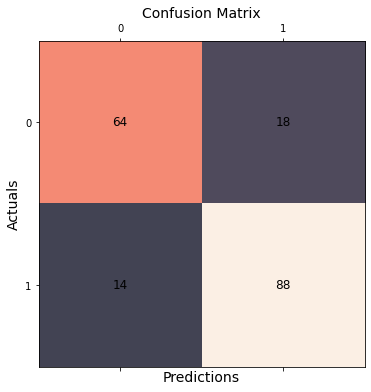

In [66]:
# Get the confussion matrix
plot_confussion_matrix(xgb_predictions)

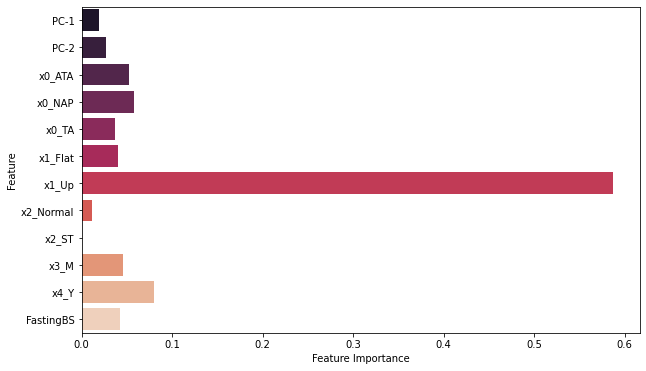

In [67]:
# Get feature importance
xgb_feature_scores = xgb_model.best_estimator_.feature_importances_.tolist()

xgb_fi = pd.DataFrame({
    'Feature': final_feats, 
    'Feature Importance': xgb_feature_scores})

plt.figure(figsize=(10,6))
sns.barplot(x = 'Feature Importance', y = 'Feature', data = xgb_fi, palette = color_palette)
plt.show()

### CatBoost

In [68]:
# Dictionnary with the parameters
catb_parameters = {
    'depth': [4, 6, 8, 10],
    'n_estimator': [10, 25, 50, 100], 
    'learning_rate': [0.001, 0.0025, 0.005, 0.0075, 0.01], 
    'loss_function': ['logloss', 'CrossEntropy']
}

# Initialise the model
catb_clf = XGBClassifier()

# Fit the model
catb_model = fit(
    catb_clf, 
    catb_parameters,
    X_train, 
    y_train
    )

print_bests(catb_model)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits
[15:05:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "depth", "loss_function", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:05:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "depth", "loss_function", "n_estimator" } might not be used.

 

In [69]:
# Make the predictions on the test
catb_predictions = predict(
    catb_model,
    X_test
    )

# Print the scores
df_results = get_scores('CatBoost', y_test, catb_predictions, df_results)
df_results

Precision: 0.838
Recall: 0.814
Accuracy: 0.810
F1 Score: 0.826
ROC-AUC Score: 0.809


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0   Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1   Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397
2                   KNN  0.880435  0.911765   0.877358  0.894231  0.876614
3                   SVM  0.864130  0.921569   0.846847  0.882629  0.857126
4         Decision Tree  0.826087  0.833333   0.850000  0.841584  0.825203
5         Random Forest  0.842391  0.872549   0.847619  0.859903  0.838714
6              AdaBoost  0.820652  0.833333   0.841584  0.837438  0.819106
7     Gradient Boosting  0.831522  0.852941   0.844660  0.848780  0.828910
8             Light GBM  0.820652  0.833333   0.841584  0.837438  0.819106
9               XGBoost  0.826087  0.862745   0.830189  0.846154  0.821616
10             CatBoost  0.809783  0.813725   0.838384  0.825871  0.809302

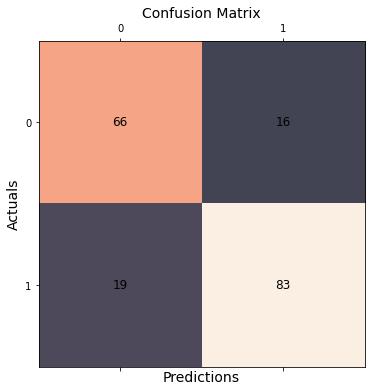

In [70]:
# Get the confussion matrix
plot_confussion_matrix(catb_predictions)

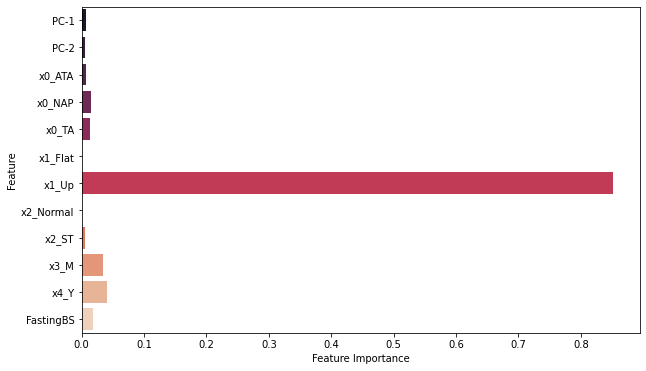

In [71]:
# Get feature importance
catb_feature_scores = catb_model.best_estimator_.feature_importances_.tolist()

catb_fi = pd.DataFrame(
    {'Feature': final_feats, 
    'Feature Importance': catb_feature_scores}
    )

plt.figure(figsize=(10,6))
sns.barplot(x = 'Feature Importance', y = 'Feature', data = catb_fi, palette = color_palette)
plt.show()

## Feedforward NN

First simple model

In [72]:
# Definition of the model
first_model = Sequential(
    [
        Dense(units = 15, activation = 'relu', input_dim = 12),      # input layer
        Dense(7, activation = 'relu'),
        Dense(4, activation = 'relu'),
        Dense(1, activation = 'sigmoid')                             # output layer
    ]
)

# Compile
first_model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['binary_accuracy']
)

In [73]:
# Fitting the model
first_model_history = first_model.fit(
    X_train,
    y_train,
    epochs = 300,
    batch_size = 100, 
    verbose = 0
)

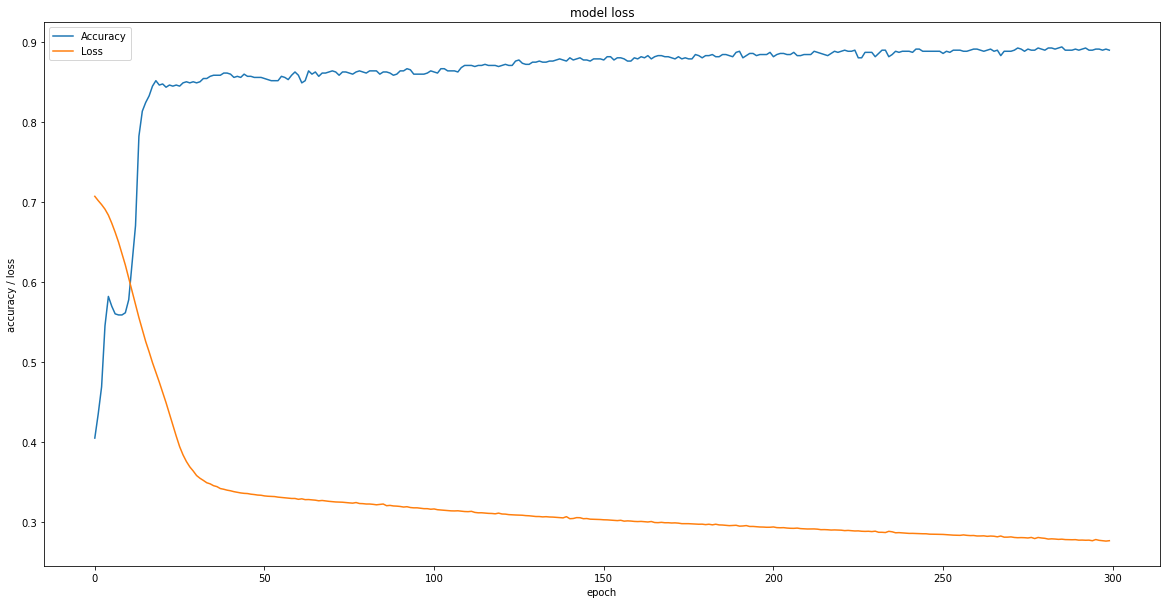

In [74]:
# Let's plot the results of the training
plt.figure(figsize = (20,10))

plt.plot(first_model_history.history['binary_accuracy'])
plt.plot(first_model_history.history['loss'])

plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.title('model loss')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')

plt.show()

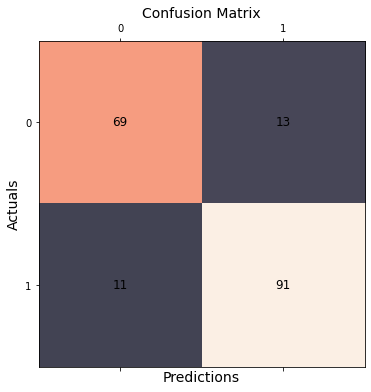

Precision: 0.875
Recall: 0.892
Accuracy: 0.870
F1 Score: 0.883
ROC-AUC Score: 0.867


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0   Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1   Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397
2                   KNN  0.880435  0.911765   0.877358  0.894231  0.876614
3                   SVM  0.864130  0.921569   0.846847  0.882629  0.857126
4         Decision Tree  0.826087  0.833333   0.850000  0.841584  0.825203
5         Random Forest  0.842391  0.872549   0.847619  0.859903  0.838714
6              AdaBoost  0.820652  0.833333   0.841584  0.837438  0.819106
7     Gradient Boosting  0.831522  0.852941   0.844660  0.848780  0.828910
8             Light GBM  0.820652  0.833333   0.841584  0.837438  0.819106
9               XGBoost  0.826087  0.862745   0.830189  0.846154  0.821616
10             CatBoost  0.809783  0.813725   0.838384  0.825871  0.809302
11             First NN  0.869565  0.892157   0.875000  0.883495  0.866810

In [75]:
# Get the predictions
nn1_predictions = first_model.predict(X_test) > 0.5

# Confussion matrix
plot_confussion_matrix(nn1_predictions)

df_results = get_scores('First NN', y_test, nn1_predictions, df_results)
df_results


Second NN model

Let's try with another activation function (swish) and let's apply some regularization.

In [76]:
# Definition of the model
second_model = Sequential(
    [ 
        Dense(units = 15, activation = 'swish', input_dim = 12),            # input layer
        Dense(10, activation = 'swish'),
        Dropout(0.15), 
        Dense(7, activation = 'swish'), 
        Dropout(0.2), 
        Dense(1, activation = 'sigmoid')                                    # output layer
    ]
)

# Compile the model
second_model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam', 
    metrics = metrics.BinaryAccuracy(threshold = 0.6)
)

# Create the early stopping callback
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min', 
    verbose = 0, 
    patience = 20
)

In [77]:
# Fiting the model
second_model_history = second_model.fit(
    X_train,
    y_train, 
    validation_data = (X_test, y_test),
    epochs = 400, 
    batch_size = 100, 
    verbose = 0, 
    callbacks = [early_stopping]
)

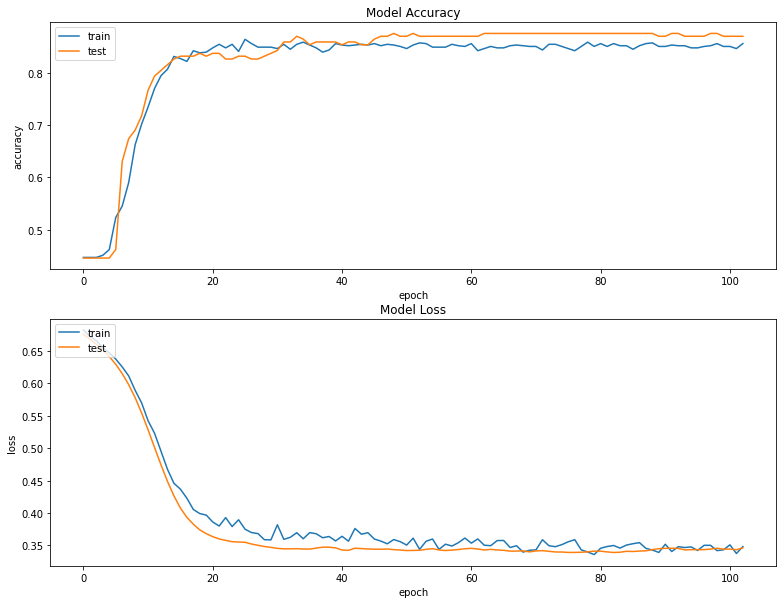

In [78]:
# Ploting the results of the training
plt.figure(figsize = (13, 10))

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(second_model_history.history['binary_accuracy'])
plt.plot(second_model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Loss
plt.subplot(2, 1, 2)
plt.plot(second_model_history.history['loss'])
plt.plot(second_model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
# Get the predictions
nn2_predictions = second_model.predict(X_test)

# Get the best prediction
i = 0
max_acc = 0
best_thres = 0
while i < 1:
    y_pred_thres = nn2_predictions > i
    accuracy  = accuracy_score(y_test, y_pred_thres)
    if max_acc < accuracy:
        max_acc = accuracy
        nn2_predictions_final = y_pred_thres
        best_thres = i
    i=i+0.05

In [80]:
df_results = get_scores('Second NN', y_test, nn2_predictions_final, df_results)
df_results

Precision: 0.850
Recall: 0.941
Accuracy: 0.875
F1 Score: 0.893
ROC-AUC Score: 0.867


Model  Accuracy    Recall  Precision  F1-score   ROC-AUC
0   Logistic Regression  0.858696  0.872549   0.872549  0.872549  0.857006
1   Gaussin Naive Bayes  0.869565  0.862745   0.897959  0.880000  0.870397
2                   KNN  0.880435  0.911765   0.877358  0.894231  0.876614
3                   SVM  0.864130  0.921569   0.846847  0.882629  0.857126
4         Decision Tree  0.826087  0.833333   0.850000  0.841584  0.825203
5         Random Forest  0.842391  0.872549   0.847619  0.859903  0.838714
6              AdaBoost  0.820652  0.833333   0.841584  0.837438  0.819106
7     Gradient Boosting  0.831522  0.852941   0.844660  0.848780  0.828910
8             Light GBM  0.820652  0.833333   0.841584  0.837438  0.819106
9               XGBoost  0.826087  0.862745   0.830189  0.846154  0.821616
10             CatBoost  0.809783  0.813725   0.838384  0.825871  0.809302
11             First NN  0.869565  0.892157   0.875000  0.883495  0.866810
12            Second NN  0.875000  0.941176   0.849558  0.893023  0.866930